**TASK 1 - Skull Stripping - Brain Segementaion**

In [ ]:
!wget https://fcp-indi.s3.amazonaws.com/data/Projects/RocklandSample/NFBS_Dataset.tar.gz && tar -xf NFBS_Dataset.tar.gz
!gdown --id 1y8N6JpKhyoLDQcscdudwMCgqubjQyfd1 
!unzip T1w_MRI_test_data.zip

Archive:  T1w_MRI_test_data.zip
   creating: T1Img/
   creating: T1Img/sub-01/
  inflating: T1Img/sub-01/T1w.nii.gz  
   creating: T1Img/sub-02/
  inflating: T1Img/sub-02/anat_img.nii.gz  
   creating: T1Img/sub-03/
  inflating: T1Img/sub-03/T1w MRI.nii  
   creating: T1Img/sub-04/
  inflating: T1Img/sub-04/T1w MRI.nii  
   creating: T1Img/sub-05/
  inflating: T1Img/sub-05/T1w MRI.nii  


In [ ]:
!pip install SimpleITK
!pip install nipype
!pip install nilearn

!wget https://fcp-indi.s3.amazonaws.com/data/Projects/RocklandSample/NFBS_BEaST_Library.tar

!tar -xf NFBS_BEaST_Library.tar

!pip install fmriprep


In [ ]:
%matplotlib inline

In [ ]:
#imports
import glob2
import SimpleITK as sitk
import numpy as np
import nibabel as nib
from nibabel.testing import data_path
import matplotlib.pyplot as plt

In [ ]:
def show_slices(slices):
   """ Function to display row of image slices """
   fig, axes = plt.subplots(1, len(slices))
   for i, slice in enumerate(slices):
       axes[i].imshow(slice.T, cmap="gray", origin="lower")

In [ ]:
#extract scan and mask
all_t1_files = glob2.glob('NFBS_Dataset/A000[0-9]*/*_T1w.nii.gz')
all_bm_files = glob2.glob('NFBS_Dataset/A000[0-9]*/*_T1w_brainmask.nii.gz')

In [ ]:
sitk.ProcessObject.SetGlobalDefaultCoordinateTolerance(1)
def prepare_training():
  X = []
  Y = []
  for i in range(20):
    print("subject ", i)
    #read image and brain mask
    inputImage = sitk.ReadImage(all_t1_files[i], sitk.sitkFloat32)
    inputImage1 = sitk.ReadImage(all_t1_files[i], sitk.sitkFloat32)
    maskImage = sitk.ReadImage(all_bm_files[i], sitk.sitkUInt8)
    #correct bias
    # corrector = sitk.N4BiasFieldCorrectionImageFilter()
    # numberFittingLevels = 4val_dice_coef
    # corrector.SetMaximumNumberOfIterations([5])
    # corrected_image = corrector.Execute(image, maskImage)
    trainImagemaskf = sitk.MaskImageFilter()
    trainImage = trainImagemaskf.Execute(inputImage, maskImage)
    # trainImage = trainImagemaskf.Execute(corrected_image, maskImage)
    #normalize between -1 to 1
    normalizationFilter = sitk.NormalizeImageFilter()
    #corrected image with mask is the output y without mask is x    
    yImage = normalizationFilter.Execute(trainImage)
    normalizationFilter = sitk.NormalizeImageFilter()
    xImage = normalizationFilter.Execute(inputImage1)
    x = sitk.GetArrayFromImage(xImage)
    y = sitk.GetArrayFromImage(yImage)
    
    for j in np.arange(0,192):
      X.append(x[j,:,:])
      Y.append(y[j,:,:])
  X = np.array(X)
  Y = np.array(Y)
  return X,Y

In [ ]:
X, Y = prepare_training()

subject  0
subject  1
subject  2
subject  3
subject  4
subject  5
subject  6
subject  7
subject  8
subject  9
subject  10
subject  11
subject  12
subject  13
subject  14
subject  15
subject  16
subject  17
subject  18
subject  19


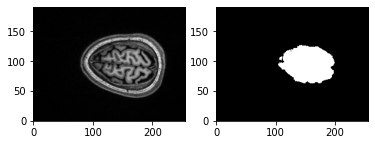

In [ ]:
#explore the data print image and mask 
#mask=label and image=data
img = nib.load(all_t1_files[1])
img_data = img.get_fdata() 
s1 = img_data[:,34,:]
img1 = nib.load(all_bm_files[1])
img_data = img1.get_fdata() 
s2 = img_data[:,34,:]
show_slices([s1,s2])

http://www.grahamwideman.com/gw/brain/orientation/orientterms.htm

https://www.slicer.org/wiki/Coordinate_systems

In [ ]:
# Model is a U-Net
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, Conv2DTranspose,MaxPooling2D, Dropout, SpatialDropout2D, UpSampling2D
from tensorflow.keras.layers import Input, concatenate, multiply,add,Activation

batch_norm=1

inputs = Input((256, 256,  1))

conv1 = Conv2D(32, (3, 3), padding='same')(inputs)
if batch_norm:
    conv1 = BatchNormalization(axis=3)(conv1)
conv1 = Activation('relu')(conv1)

conv1 = Conv2D(32, (3, 3), padding='same')(conv1)
if batch_norm:
    conv1 = BatchNormalization(axis=3)(conv1)
conv1 = Activation('relu')(conv1)

pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(64, (3, 3), padding='same')(pool1)
if batch_norm:
    conv2 = BatchNormalization(axis=3)(conv2)
conv2 = Activation('relu')(conv2)

conv2 = Conv2D(64, (3, 3), padding='same')(conv2)
if batch_norm:
    conv2 = BatchNormalization(axis=3)(conv2)
conv2 = Activation('relu')(conv2)

pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(128, (3, 3), padding='same')(pool2)
if batch_norm:
    conv3 = BatchNormalization(axis=3)(conv3)
conv3 = Activation('relu')(conv3)

conv3 = Conv2D(128, (3, 3), padding='same')(conv3)
if batch_norm:
    conv3 = BatchNormalization(axis=3)(conv3)
conv3 = Activation('relu')(conv3)

pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(256, (3, 3), padding='same')(pool3)
if batch_norm:
    conv4 = BatchNormalization(axis=3)(conv4)
conv4 = Activation('relu')(conv4)

conv4 = Conv2D(256, (3, 3), padding='same')(conv4)
if batch_norm:
    conv4 = BatchNormalization(axis=3)(conv4)
conv4 = Activation('relu')(conv4)

pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(512, (3, 3), padding='same')(pool4)
if batch_norm:
    conv5 = BatchNormalization(axis=3)(conv5)
conv5 = Activation('relu')(conv5)

conv5 = Conv2D(512, (3, 3), padding='same')(conv5)
if batch_norm:
    conv5 = BatchNormalization(axis=3)(conv5)
conv5 = Activation('relu')(conv5)

up6 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5)
up6 = concatenate([up6, conv4], axis=3)

conv6 = Conv2D(256, (3, 3), padding='same')(up6)
if batch_norm:
    conv6 = BatchNormalization(axis=3)(conv6)
conv6 = Activation('relu')(conv6)

conv6 = Conv2D(256, (3, 3), padding='same')(conv6)
if batch_norm:
    conv6 = BatchNormalization(axis=3)(conv6)
conv6 = Activation('relu')(conv6)

up7 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6)
up7 = concatenate([up7, conv3], axis=3)

conv7 = Conv2D(128, (3, 3), padding='same')(up7)
if batch_norm:
    conv7 = BatchNormalization(axis=3)(conv7)
conv7 = Activation('relu')(conv7)

conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
if batch_norm:
    conv7 = BatchNormalization(axis=3)(conv7)
conv7 = Activation('relu')(conv7)

up8 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7)
up8 = concatenate([up8, conv2], axis=3)

conv8 = Conv2D(64, (3, 3), padding='same')(up8)
if batch_norm:
    conv8 = BatchNormalization(axis=3)(conv8)
conv8 = Activation('relu')(conv8)

conv8 = Conv2D(64, (3, 3), padding='same')(conv8)
if batch_norm:
    conv8 = BatchNormalization(axis=3)(conv8)
conv8 = Activation('relu')(conv8)

up9 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8)
up9 = concatenate([up9, conv1], axis=3)

conv9 = Conv2D(32, (3, 3), padding='same')(up9)
if batch_norm:
    conv9 = BatchNormalization(axis=3)(conv9)
conv9 = Activation('relu')(conv9)

conv9 = Conv2D(32, (3, 3), padding='same')(conv9)
if batch_norm:
    conv9 = BatchNormalization(axis=3)(conv9)
conv9 = Activation('relu')(conv9)

conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

model = Model(inputs=[inputs], outputs=[conv10])

In [ ]:
model.summary()

In [ ]:
# from sklearn.model_selection import train_test_split
t=int(3840-(3840*0.4))
# t1 = 2304
# t2 = 2305:3840
X_train = X[0:2304,:,:] 
y_train = Y[0:2304,:,:]
X_val = X[2305:3072,:,:]
y_val = Y[2305:3072, :,: ]
X_test = X[ 3073:3840,:,:]
y_test = Y[ 3073:3840,:,:]


In [ ]:
import os
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam

def dice_coef(y_true, y_pred, smooth=1):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

base_lr = 1e-3

optimizer = Adam(lr=base_lr)

model.compile(optimizer=optimizer,
              loss=dice_coef_loss,
              metrics=[dice_coef])

# os.mkdir("logs")
# os.mkdir("weigths")

# training_log = TensorBoard(log_dir="logs")
import tensorflow as tf
filepath = '/content/model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', save_best_only=True, mode='auto')

history = model.fit(X_train, y_train,
          validation_data=(X_test, y_test),
          batch_size=32,
          epochs=30,
          shuffle=True,
          callbacks=[checkpoint])
exp=1
model.save_weights("weights", 'weights_1_{}.h5'.format(exp))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/30
72/72 [==============================] - 103s 838ms/step - loss: 0.1263 - dice_coef: 0.8737 - val_loss: 0.1977 - val_dice_coef: 0.8023
Epoch 2/30
72/72 [==============================] - 55s 764ms/step - loss: 0.1115 - dice_coef: 0.8885 - val_loss: 0.1721 - val_dice_coef: 0.8279
Epoch 3/30
72/72 [==============================] - 54s 754ms/step - loss: 0.1103 - dice_coef: 0.8897 - val_loss: 0.1693 - val_dice_coef: 0.8307
Epoch 4/30
72/72 [==============================] - 55s 759ms/step - loss: 0.1097 - dice_coef: 0.8903 - val_loss: 0.1337 - val_dice_coef: 0.8663
Epoch 5/30
72/72 [==============================] - 55s 762ms/step - loss: 0.1093 - dice_coef: 0.8907 - val_loss: 0.1146 - val_dice_coef: 0.8854
Epoch 6/30
72/72 [==============================] - 54s 757ms/step - loss: 0.1106 - dice_coef: 0.8894 - val_loss: 0.4668 - val_dice_coef: 0.5332
Epoch 7/30
72/72 [==============================] - 55s 760ms/step - loss: 0.1099 - dice_coef: 0.8901 - val_loss: 0.1372 - val_di

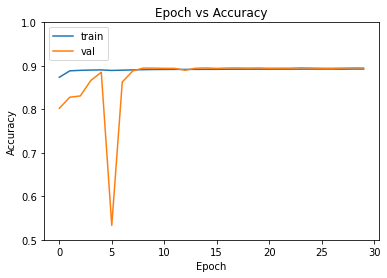

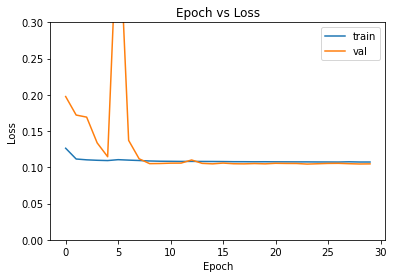

In [ ]:
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title("Epoch vs Accuracy")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim([0.5,1])
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Epoch vs Loss")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim([0,0.3])
plt.legend(['train', 'val'], loc='upper right')
plt.show()

Predict the brain mask for test set

In [ ]:
# predict for all test data
img_pred = model.predict(X_test, verbose=1)

24/24 [==============================] - 5s 205ms/step


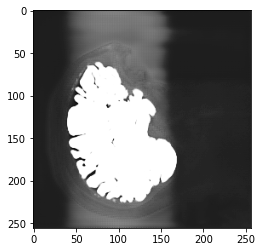

In [ ]:
# predicted brain mask 
plt.imshow(img_pred[450,:,:,:].reshape(256,256).T,cmap="gray")

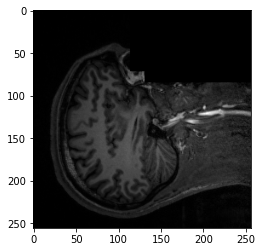

In [ ]:
#input image
plt.imshow(X_test[450,:,:].reshape(256,256).T,cmap="gray")

In [ ]:
##uncomment to load trained model weights
# !gdown --id 1mu7M_mbqIVRcs7xouaODfB3QxIbsI6C-
# model.load_weights("model.h5")

Downloading...
From: https://drive.google.com/uc?id=1mu7M_mbqIVRcs7xouaODfB3QxIbsI6C-
To: /content/model.h5
93.6MB [00:05, 17.6MB/s]


In [ ]:
#Load all the Test Files from given in PDF 
all_brt_files = glob2.glob('/content/T1Img/sub-[0-9]*/*.nii*')

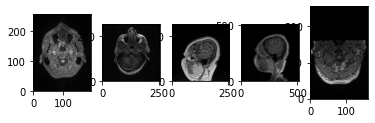

In [ ]:
#Examine Inputs 
slices = []
for i in range(len(all_brt_files)):
  img = nib.load(all_brt_files[i])
  img_data = img.get_fdata() 
  s1 = img_data[:,:,34]
  slices.append(s1)
show_slices(slices)

In [ ]:
#Examine shapes 
for i in range(len(all_brt_files)):
  img = nib.load(all_brt_files[i])
  img_data = img.get_fdata() 
  print(img_data.shape)

(192, 256, 256)
(256, 256, 166)
(256, 256, 176)
(512, 512, 176)
(160, 256, 256)


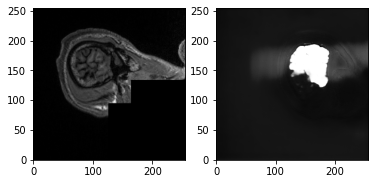

In [ ]:
# Test first mri on the model 
img = nib.load(all_brt_files[i])
img_data = img.get_fdata() 
s1 = X[37,:,:]
s2 = np.flip(predic_2[37,:,:].reshape(256,256).T)
show_slices([s1,s2])

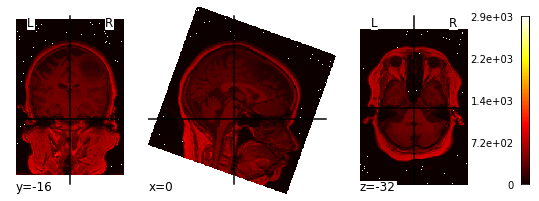

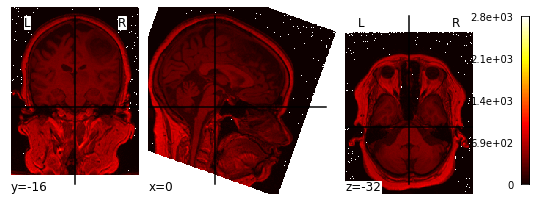

In [ ]:
#example output after resample and rotate the data
import nibabel
import nibabel.processing
from nilearn.image import resample_to_img
from nilearn.image import load_img
from nilearn import plotting

input_img = nibabel.load(all_t1_files[2])

stat_img = load_img(all_brt_files[2])
resampled_stat_img = resample_to_img(stat_img, input_img)


plotting.plot_stat_map(stat_img)
plotting.plot_stat_map(resampled_stat_img)
plotting.show()

In [ ]:
resampled_stat_img.shape

(256, 256, 192)

In [ ]:
def prepare_training_br():
  X = []
  input_template = nibabel.load(all_t1_files[2])
  for i in range(len(all_brt_files)):
    print("subject ", i)
    #normalization filter applied to the image array
    normalizationFilter = sitk.NormalizeImageFilter()
    stat_img = load_img(all_brt_files[i])
    resampled_stat_img = resample_to_img(stat_img, input_template)
    rsi =sitk.GetImageFromArray(resampled_stat_img.get_fdata())
    xImage = normalizationFilter.Execute(rsi)
    x = sitk.GetArrayFromImage(xImage)
    X.append(x)
  X = np.array(X)
  print(X.shape)
  return X
X=prepare_training_br()

subject  0


/usr/local/lib/python3.7/dist-packages/nilearn/image/resampling.py:527: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


subject  1


/usr/local/lib/python3.7/dist-packages/nilearn/image/resampling.py:527: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


subject  2
subject  3
subject  4


/usr/local/lib/python3.7/dist-packages/nilearn/image/resampling.py:527: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


(5, 256, 256, 192)


In [ ]:
subj1_predicted = model.predict(X[0,:,:,:].T)

In [ ]:
subj2_predicted = model.predict(X[1,:,:,:].T)
subj3_predicted = model.predict(X[2,:,:,:].T)
subj4_predicted = model.predict(X[3,:,:,:].T)
subj5_predicted = model.predict(X[4,:,:,:].T)

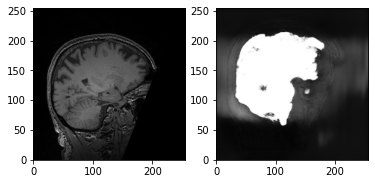

In [ ]:
#Visual testing ground
img = nib.load(all_brt_files[4])
img_data = img.get_fdata() 
s1 = img_data[100,:,:]
s2 = np.flip(subj5_predicted[100,:,:].reshape(256,256).T)
show_slices([s1,s2])



**TASK 2 - ICA and DMN**




In [ ]:
!gdown --id 1B6Zy_3FXp5eCa--RMXEnojEW3Trhm-7K &&

Downloading...
From: https://drive.google.com/uc?id=1B6Zy_3FXp5eCa--RMXEnojEW3Trhm-7K
To: /content/ML Neuroscience Task - Helper Data.zip
128MB [00:02, 63.6MB/s]


In [ ]:
 !unzip /content/ML\ Neuroscience\ Task\ -\ Helper\ Data.zip

Archive:  /content/ML Neuroscience Task - Helper Data.zip
   creating: ML Neuroscience Task - Helper Data/
   creating: ML Neuroscience Task - Helper Data/Preprocessed rs-fMRI scan/
  inflating: ML Neuroscience Task - Helper Data/Preprocessed rs-fMRI scan/Filtered_4DVolume.nii  


In [ ]:
path_to_preprocessed = "/content/ML Neuroscience Task - Helper Data/Preprocessed rs-fMRI scan/Filtered_4DVolume.nii"

In [ ]:
from nilearn.decomposition import CanICA
canica = CanICA(n_components=12,
                memory="nilearn_cache", memory_level=1,
                verbose=1,
                mask_strategy='template',
                random_state=2)
canica.fit(path_to_preprocessed)


[MultiNiftiMasker.fit] Loading data from [/content/ML Neuroscience Task - Helper Data/Preprocessed rs-fMRI scan/Filtered_4DVolume.nii]
[MultiNiftiMasker.fit] Computing mask
[MultiNiftiMasker.transform] Resampling mask
[CanICA] Loading data


/usr/local/lib/python3.7/dist-packages/nilearn/_utils/cache_mixin.py:303: UserWarning: memory_level is currently set to 0 but a Memory object has been provided. Setting memory_level to 1.
  warnings.warn("memory_level is currently set to 0 but "
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-pack

CanICA(detrend=True, do_cca=True, high_pass=None, low_pass=None, mask=None,
       mask_args=None, mask_strategy='template',
       memory=Memory(location=nilearn_cache/joblib), memory_level=1,
       n_components=12, n_init=10, n_jobs=1, random_state=2, smoothing_fwhm=6,
       standardize=True, standardize_confounds=True, t_r=None,
       target_affine=None, target_shape=None, threshold='auto', verbose=1)

/usr/local/lib/python3.7/dist-packages/nilearn/plotting/displays.py:103: UserWarning: No contour levels were found within the data range.
  **kwargs)
/usr/local/lib/python3.7/dist-packages/nilearn/plotting/displays.py:103: UserWarning: linewidths is ignored by contourf
  **kwargs)


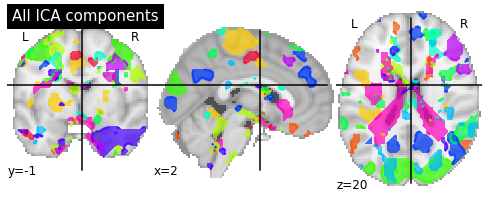

In [ ]:

from nilearn.plotting import plot_prob_atlas

canica_components_img = canica.components_img_

# Plot all ICA components together

plot_prob_atlas(canica_components_img, title='All ICA components')
